In [233]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

### Create dataset

In [234]:
x= torch.linspace(0,799,800)
y = torch.sin(x*2*3.1416/40)

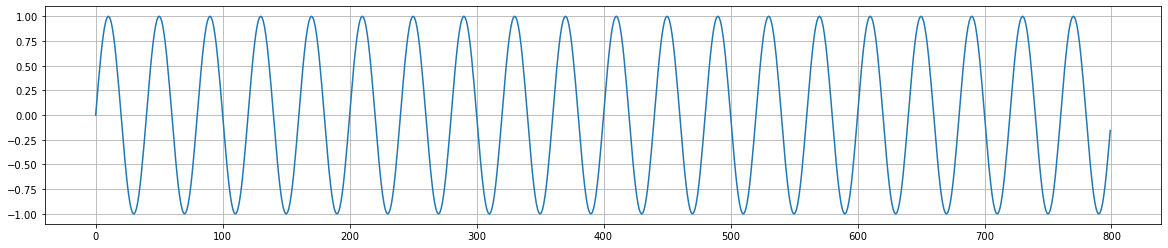

In [235]:
plt.figure(figsize=(20,4))
plt.plot(x, y)
plt.grid(True)
plt.show()

In [236]:
class SineDataSet(Dataset):
    def __init__(self, series, window_size, num_future_pt):
        self.series = series
        self.window_size = window_size
        self.num_future_pt = num_future_pt
        
    def __getitem__(self, idx):
        X = self.series[idx: idx + self.window_size]
        y = self.series[idx + self.window_size:idx+ self.window_size + self.num_future_pt]
        return X,y
    
    def __len__(self):
        return len(self.series) - self.window_size - self.num_future_pt

In [237]:
#train test split
train = y[:760]
test = y[760:]

In [238]:
num_futures = 4
window_size= 40
batch_size= 1
train_ds = SineDataSet(train, window_size, num_futures)
test_ds  = SineDataSet(test, window_size, num_futures)

### Model building (Univariate Seq2Seq)

In [239]:
class EncoderRNN(nn.Module):
    
    def __init__(self, num_features, num_hidden, batch_size):
        super().__init__()
        self.input_size = num_features
        self.hidden_size = num_hidden
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size= self.input_size, hidden_size=self.hidden_size, batch_first=True)
        self.hidden = (torch.zeros(1,self.batch_size,self.hidden_size), torch.zeros(1,self.batch_size,self.hidden_size))
    
    def reset_hidden(self):
        self.hidden = (torch.zeros(1,self.batch_size,self.hidden_size), torch.zeros(1,self.batch_size,self.hidden_size))
        
    def forward(self, seq):
        seq = seq.view(self.batch_size,len(seq), -1)
        out_lstm, hidden = self.lstm(seq, self.hidden)
        return out_lstm, hidden

In [240]:
class DecoderRNN(nn.Module):
    def __init__(self, num_features, num_hidden, num_output, batch_size):
        super().__init__()
        self.hidden_size = num_hidden
        self.num_output = num_output
        self.input_size = num_features
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size= self.hidden_size, batch_first=True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=num_output)
        
    def forward(self, seq, hidden):
        seq = seq.view(self.batch_size,len(seq), -1)
        out_lstm, out_hidden = self.lstm(seq, hidden)
        out = self.linear(out_lstm.view(len(out_lstm), -1))
        return out, hidden

In [241]:
class Seq2Seq(nn.Module):
    def __init__(self, num_features, num_hidden, num_output, num_futures, batch_size):
        super().__init__()
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.num_futures = num_futures
        self.batch_size = batch_size
        
        self.encoder = EncoderRNN(self.num_features, self.num_hidden, batch_size)
        self.decoder = DecoderRNN(self.num_features, self.num_hidden, self.num_output, batch_size)
        
    def reset_hidden(self):
        self.encoder.reset_hidden()
    
    def forward(self, seq, prev_y):
        encoder_out, encoder_hidden = self.encoder(seq)
        #placeholder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        prev_out = prev_y
        prev_hidden = encoder_hidden
        
        for future_data in range(self.num_futures):
            decoder_out, decoder_hidden = self.decoder(prev_out, prev_hidden)
            prev_out = decoder_out
            prev_hidden = decoder_hidden
            targets_ta.append(prev_out.reshape(self.batch_size))
        
        targets = torch.stack(targets_ta, dim=1)
        return targets

In [242]:
num_features = 1
num_hidden = 50
num_output = 1

model = Seq2Seq(num_features, num_hidden, num_output, num_futures, batch_size)

In [243]:
model

Seq2Seq(
  (encoder): EncoderRNN(
    (lstm): LSTM(1, 50, batch_first=True)
  )
  (decoder): DecoderRNN(
    (lstm): LSTM(1, 50, batch_first=True)
    (linear): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [244]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() 

### Model Training

In [245]:
epochs = 10

for e in range(epochs):
    losses = []
    for i in range(len(train_ds)):
        train_features, train_label = train_ds[i]
        optimizer.zero_grad()
        model.reset_hidden()
        input_features = train_features[-1:]
        seq_pred = model(train_features, input_features)
        loss = criterion(seq_pred, train_label.unsqueeze(dim=0))
        loss.backward()
        optimizer.step()
        losses.append(loss)
    print(f"Epoch {e} Loss: {loss}")

Epoch 0 Mean of RMSE per epoch: 0.3276483714580536
Epoch 1 Mean of RMSE per epoch: 0.2514978349208832
Epoch 2 Mean of RMSE per epoch: 0.1863582730293274
Epoch 3 Mean of RMSE per epoch: 0.1447039097547531
Epoch 4 Mean of RMSE per epoch: 0.15080299973487854
Epoch 5 Mean of RMSE per epoch: 0.12877090275287628
Epoch 6 Mean of RMSE per epoch: 0.1615864783525467
Epoch 7 Mean of RMSE per epoch: 0.11430678516626358
Epoch 8 Mean of RMSE per epoch: 0.12006799876689911
Epoch 9 Mean of RMSE per epoch: 0.12232349812984467


### Model Evaluation

In [249]:
preds = train[-window_size:].tolist()
model.eval()
futures = 40
test_batch = 1

for i in range(int(futures/num_futures)):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.reset_hidden()
        predictions = model(seq, seq[-1:])
        preds += predictions.flatten().tolist()

In [250]:
x_axis = np.linspace(760, 799, 40); x_axis

array([760., 761., 762., 763., 764., 765., 766., 767., 768., 769., 770.,
       771., 772., 773., 774., 775., 776., 777., 778., 779., 780., 781.,
       782., 783., 784., 785., 786., 787., 788., 789., 790., 791., 792.,
       793., 794., 795., 796., 797., 798., 799.])

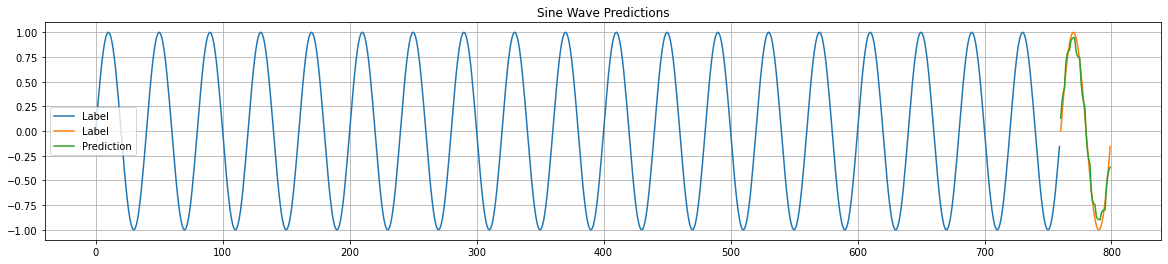

In [252]:
plt.figure(figsize=(20,4))
plt.title("Sine Wave Predictions")
plt.grid(True)
plt.plot(train, label="Label")
plt.plot(x_axis, test, label="Label")
plt.plot(x_axis, preds[-futures:], label="Prediction")
plt.legend()
plt.show()